In [3]:
# Importation 
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import os
import openpyxl
from tsfresh import extract_features, select_features
directory = os.getcwd()

# Graphe d'évolution du NDVI

<AxesSubplot: title={'center': "Evolution du NDVI sur l'année"}, xlabel='date', ylabel='NDVI'>

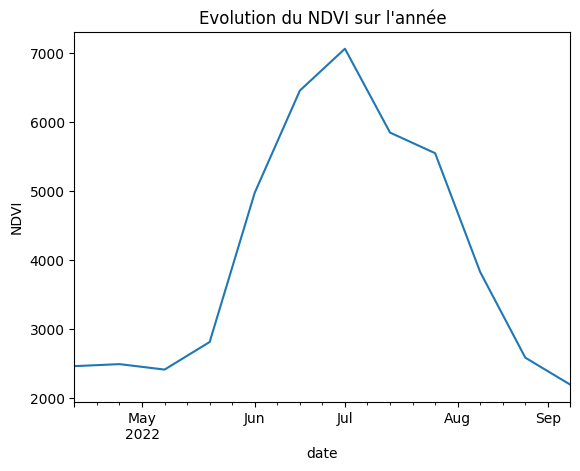

In [4]:
# Importation données NDVI
donnees = pd.read_csv(f"{directory}/donnees/resultats-2.csv", sep = ";", parse_dates = ["date"], dayfirst = True)

# Typage des colonnes
donnees['parcelle'] = donnees['parcelle'].astype('string')
donnees["parcelle"] = donnees["parcelle"].map(lambda x:x.replace('_','').lower())
donnees.columns = donnees.columns.str.replace('NDVI_moy', 'ndvi')
donnees = donnees.set_index('date', drop = False)

donnees["campagne"] = donnees["date"].dt.year # on utilise cette colonne campagne pour les jointures pr récup le peuplement et le précédent
donnees['campagne'] = donnees['campagne'].astype('string')

# Graphe évolution NDVI moyenné par mois
# sns.lineplot(x="date", y="ndvi", data=donnees, hue="parcelle", legend = False)
donnees["ndvi"].resample("2W").mean().plot(title = "Evolution du NDVI sur l'année", ylabel = "NDVI")

# Intégration du target (peuplement)

In [5]:
peuplement_1 = pd.read_excel(f"{directory}/donnees/peuplement/donnees2022_BA-2.xlsx", engine='openpyxl', parse_dates = ["date"])
peuplement_1 = peuplement_1.loc[:,["parcelle","date","peuplement"]]

peuplement_2 = pd.read_excel(f"{directory}/donnees/peuplement/Placette_TRN22_beauce.xlsx", engine='openpyxl', parse_dates = ["date_obs"])
peuplement_2 = peuplement_2.loc[:,["numero_parcelle","date_obs","peuplement"]]
peuplement_2.columns = peuplement_2.columns.str.replace('numero_parcelle', 'parcelle')
peuplement_2.columns = peuplement_2.columns.str.replace('date_obs','date')
peuplement_2 = peuplement_2[peuplement_2["parcelle"] != "80_22"] # la dernière ligne a un NA dans col peuplement

peuplement = peuplement_1.merge(peuplement_2)
peuplement = pd.concat([peuplement_1, peuplement_2], axis = 0, ignore_index = True)
peuplement["parcelle"] = peuplement["parcelle"].map(lambda x:x.replace('_','').lower())
peuplement['parcelle'] = peuplement['parcelle'].astype('string')
peuplement = peuplement.groupby(["parcelle"]).agg({"date":["first"], "peuplement":["mean"]})
peuplement.columns = peuplement.columns.droplevel()
peuplement.columns = ["date","peuplement"]
peuplement = peuplement.reset_index()

# Intégration aux données NDVI
peuplement["campagne"] = peuplement["date"].dt.year.map(lambda x:int(x))
peuplement['campagne'] = peuplement['campagne'].astype('string')
peuplement = peuplement.drop(["date"], axis = 1)

donnees = donnees.merge(peuplement,on=['campagne','parcelle'],how='left')

donnees['parcelle'] = donnees['parcelle'].astype('string')

# Intégration des données cultures précédentes

In [6]:
# Fichiers avec données cultures précédentes
filenames = glob.glob(f"{directory}/donnees/precedents/*.csv")

# tableau où on agrège toutes les données cultures précédentes
donnees_precedent = pd.read_csv(filenames[0], sep = ";")

for file in filenames[1:]:
    donnees_precedent_tmp = pd.read_csv(file, sep = ";")
    donnees_precedent = pd.concat([donnees_precedent,donnees_precedent_tmp], axis = 0)

donnees_precedent = donnees_precedent.drop(["ID_PARCEL"], axis = 1)

# Typage des colonnes
donnees_precedent.columns = donnees_precedent.columns.str.replace('CODE_CULTU', 'precedent')
donnees_precedent['precedent'] = donnees_precedent['precedent'].astype('string')
donnees_precedent['campagne'] = donnees_precedent['campagne'].astype('string')
donnees_precedent["NomPar"] = donnees_precedent["NomPar"].map(lambda x:x.replace('_','').lower())
donnees_precedent.columns = donnees_precedent.columns.str.replace('NomPar', 'parcelle')
donnees_precedent['parcelle'] = donnees_precedent['parcelle'].astype('string')

# Jointure avec table de données NDVI
donnees = donnees.merge(donnees_precedent,on=['campagne','parcelle'],how='left')

print("nombre de couples parcelle-campagne : ", donnees.loc[:,["parcelle","campagne"]].drop_duplicates().shape[0])
print("nombre de couples parcelle-campagne pour lesquels on n'a pas le précédent : ", donnees.iloc[donnees.loc[:,["parcelle","campagne"]].drop_duplicates().index,:].precedent.isna().sum())
print("précédents des couples parcelle-campagne pour lesquels on a le précédent",donnees.iloc[donnees.loc[:,["parcelle","campagne"]].drop_duplicates().index,:].precedent.value_counts())
donnees = donnees.drop(["precedent"], axis = 1)

# On construit des features issues des données précédents
features_precedent = pd.concat([donnees_precedent.loc[:,["parcelle","campagne"]], pd.get_dummies(donnees_precedent.precedent)], axis = 1)

nombre de couples parcelle-campagne :  45
nombre de couples parcelle-campagne pour lesquels on n'a pas le précédent :  3
précédents des couples parcelle-campagne pour lesquels on a le précédent BTH    15
ORP    14
BDH     3
MIS     2
BDP     2
ORH     2
CZH     1
MLT     1
SOG     1
FVL     1
Name: precedent, dtype: Int64


# Intégration des données météo et Génération de features

In [557]:
# Importation du fichier de mapping station-parcelle
mapping_meteo_parcelle = pd.read_csv(f"{directory}/donnees/table_parcelles_v2.csv", sep = ";")
mapping_meteo_parcelle['campagne'] = mapping_meteo_parcelle['campagne'].astype('string')
mapping_meteo_parcelle['station_meteo'] = mapping_meteo_parcelle['station_meteo'].astype('string')

# Fichiers avce données météo
filenames = glob.glob("/Users/etienneperez/Documents/IODAA/Projet fil rouge/donnees/meteo/*.csv")

# tableau où on agrège toutes les données météo avec 1 col station_meteo et 1 col campagne pr ensuite mapper au num de parcelle
donnees_meteo = pd.read_csv(filenames[0], sep = ";")
donnees_meteo = pd.concat([donnees_meteo, pd.DataFrame(np.array([[filenames[0][-8:-4], filenames[0][-22:-18]] for i in range(donnees_meteo.shape[0])]),columns=['campagne', 'station_meteo'])], axis = 1)
donnees_meteo.columns = donnees_meteo.columns.str.replace('Date', 'date')

for file in filenames[1:]:
    donnees_meteo_tmp = pd.read_csv(file, sep = ";")
    donnees_meteo_tmp.columns = donnees_meteo_tmp.columns.str.replace('Date', 'date') # parfois y'avait une maj, et parfois non, ça uniformise ça
    donnees_meteo_tmp = pd.concat([donnees_meteo_tmp, pd.DataFrame(np.array([[file[-8:-4], file[-22:-18]] for i in range(donnees_meteo_tmp.shape[0])]),columns=['campagne', 'station_meteo'])], axis = 1)
    donnees_meteo = pd.concat([donnees_meteo, donnees_meteo_tmp], axis = 0, ignore_index = True)

donnees_meteo['campagne'] = donnees_meteo['campagne'].astype('string')
donnees_meteo['station_meteo'] = donnees_meteo['station_meteo'].astype('string')

# Jointure avec table de mapping station-parcelle (on perd index temporel)
donnees_meteo = donnees_meteo.merge(mapping_meteo_parcelle,on=['campagne','station_meteo'],how='left')

# Typage des colonnes pour jointure avec donnees NDVI et précédents
donnees_meteo["NomPar"] = donnees_meteo["NomPar"].map(lambda x:x.replace('_','').lower())
donnees_meteo['NomPar'] = donnees_meteo['NomPar'].astype('string')
donnees_meteo['date'] =  pd.to_datetime(donnees_meteo['date'], dayfirst = True)

donnees_meteo.columns = donnees_meteo.columns.str.replace('NomPar', 'parcelle')
donnees_meteo = donnees_meteo.set_index("date")

# On construit des features issues des données météo
donnees_meteo["secheresse"] = donnees_meteo.ETP - donnees_meteo.Pluie
donnees_meteo["mois"] = donnees_meteo.index.month
dico_mois = {'1':'janvier','2':'fevrier','3':'mars','4':'avril','5':'mai','6':'juin','7':'juillet','8':'aout','9':'septembre'}

features_meteo = donnees_meteo.groupby(["parcelle","campagne","mois"], as_index=False).secheresse.mean()
features_meteo['mois'] = features_meteo['mois'].astype('string')
features_meteo = features_meteo.pivot(index=['parcelle','campagne'], columns='mois', values='secheresse').reset_index().rename(columns = dico_mois)
features_meteo.head()

mois,parcelle,campagne,fevrier,mars,avril,mai,juin,juillet
0,0222,2022,0.075000,1.388387,1.352,2.635806,1.269,4.554516
1,0522,2022,0.075000,1.388387,1.352,2.635806,1.269,4.554516
2,0622,2022,0.075000,1.388387,1.352,2.635806,1.269,4.554516
3,10022,2022,0.075000,1.388387,1.352,2.635806,1.269,4.554516
4,100gers2019,2019,0.617857,1.603226,0.610,1.045161,3.510,3.406452


# Feature Generation & Selection à partir des NDVI

In [326]:
donnees = donnees.sort_values(["parcelle","date"])
donnees = donnees.dropna(axis = 0, subset=['peuplement'])

df = donnees.loc[:,["parcelle","date","ndvi"]]
y = donnees.loc[:,["parcelle","peuplement","campagne"]].drop_duplicates().peuplement

y = y.reset_index(drop = True)
df = df.reset_index(drop = True)

In [327]:
extracted_features_df = extract_features(timeseries_container = df, column_id = "parcelle", column_sort = "date", n_jobs=4)
# Cela crée 1 ligne par parcelle
# Et pour chaque ligne il génère x features

Feature Extraction: 100%|██████████| 14/14 [00:05<00:00,  2.59it/s]


In [328]:
extracted_features_df.shape
# Pour les 45 parcelles, tsfresh a extrait 783 features à partir du ndvi

(41, 783)

In [381]:
# On ne conserve que les features sans NA dans la colonne
extracted_features_df = extracted_features_df.dropna(axis = 1)
print("nb de features : ", extracted_features_df.shape[1])

nb de features :  326


In [407]:
selected_features_df = select_features(extracted_features_df, y.values)
# On sélectionne les caractéristiques
# Un peu flou comme il sélec : il teste la "significativé au target"
print("nb de features sélectionnées : ",selected_features_df.shape[1])

nb de features sélectionnées :  6


In [409]:
extracted_features_df.shape

(41, 326)

In [422]:
# Alternative à select_features --> PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 4) # 99% de la variance expliquée
pca.fit(extracted_features_df)

print(pca.components_.T.shape)
print(extracted_features_df.shape)
selected_features_df = extracted_features_df @ pca.components_.T
selected_features_df

(326, 4)
(41, 326)


,0,1,2,3
1722,2.663596e+11,2.620300e+11,-1.183138e+10,-2.464672e+09
2822,1.786793e+11,2.006270e+11,-1.762171e+10,-2.420140e+10
2922,1.661118e+11,9.890289e+10,-1.910683e+10,1.667846e+10
3822,3.325181e+11,1.060514e+11,-4.364023e+10,2.140196e+10
4222,2.580174e+11,1.108333e+11,-1.459227e+10,1.087881e+10
4422,3.755887e+11,1.245150e+11,-1.030010e+10,7.418553e+09
4522,9.756881e+10,3.304375e+11,-3.319732e+10,-1.635068e+10
4722,2.900534e+11,1.033906e+11,-1.506630e+10,7.259050e+09
5222,1.325595e+11,2.833449e+11,-1.319512e+10,-1.165322e+10
5322,7.535797e+11,1.313455e+11,3.492879e+10,-3.784037e+09


# Entrainement d'un modèle
Pour l'instant je n'ai entrainé que des modèles avec de la feature generation & seleciton sur le ndvi, mtn il faut voir ce qu'apportent les features liées au peuplement et à la sécheresse dans features_precedent et features_meteo

In [423]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

X_train, X_test, y_train, y_test = train_test_split(selected_features_df, y, test_size=0.3, random_state=0)

# mod_svr = SVR(epsilon=0.2, kernel = 'linear')
# param_grid = {'C': [0.01,0.1, 1, 10, 100]}
# grid = GridSearchCV(mod_svr, param_grid = param_grid, scoring = 'neg_mean_squared_error', n_jobs=3)
# grid.fit(X_train,y_train)

# mod_linear = LinearRegression()
# mod_linear.fit(X_train,y_train)

# n_neighbors = 5
param_grid = {'n_neighbors': [3,5,7,9], 'weights' : ['uniform','distance']}
mod_knn = KNeighborsRegressor()
grid = GridSearchCV(mod_knn, param_grid = param_grid, n_jobs = 3)
# grid.fit(X_train,y_train)
grid.fit(X_train,y_train)



GridSearchCV(estimator=KNeighborsRegressor(), n_jobs=3,
             param_grid={'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']})

In [424]:
y_pred_train = grid.best_estimator_.predict(X_train)
y_pred_test = grid.best_estimator_.predict(X_test)
print(r2_score(y_train,y_pred_train))
print(r2_score(y_test,y_pred_test))

1.0
-1.1096872984123207


In [382]:
X_test.values

array([[3.78240347e+03, 1.95370182e+03, 3.81695080e+06, 3.78715160e+05,
        1.55756928e+03, 3.19206440e+00],
       [2.78510108e+03, 1.35081077e+03, 1.82468973e+06, 7.33848100e+04,
        1.92701099e+03, 3.30039131e+00],
       [3.51538817e+03, 1.36386759e+03, 1.86013481e+06, 3.70472816e+05,
        8.16582884e+02, 2.52124599e+00],
       [4.02406523e+03, 1.90720070e+03, 3.63741451e+06, 4.99274000e+05,
        1.17892477e+03, 2.70480298e+00],
       [5.71440793e+03, 2.17512914e+03, 4.73118678e+06, 1.45119475e+06,
        1.69095243e+03, 2.26383092e+00],
       [5.25909070e+03, 2.51646918e+03, 6.33261714e+06, 9.09576734e+05,
        1.50713716e+03, 2.23645569e+00],
       [3.81438920e+03, 1.55985425e+03, 2.43314529e+06, 5.31640204e+05,
        1.06415857e+03, 2.54585945e+00],
       [6.35180651e+03, 2.19976225e+03, 4.83895395e+06, 8.46985889e+05,
        2.00509182e+03, 1.53942152e+00],
       [2.94052512e+03, 1.22851187e+03, 1.50924141e+06, 5.52518056e+04,
        8.73752086e+02, 